In [40]:
pip install huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install plotly nbformat

Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from huggingface_hub import hf_hub_download

In [43]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
import warnings
REPO_ID = "lainmn/AgentDS-Healthcare"
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

train_stays = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/stays_train.csv", repo_type="dataset"))
test_stays = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/stays_test.csv", repo_type="dataset"))
patients = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/patients.csv", repo_type="dataset"))

with open(hf_hub_download(REPO_ID, "Healthcare/vitals_timeseries.json", repo_type="dataset"), 'r') as f:
    vitals_data = json.load(f)

train_df = train_stays.merge(patients, on='patient_id', how='left')
train_df['Discharge Status'] = train_df['discharge_ready_day11'].map({
    0: 'Not Ready by Day 11',
    1: 'Ready by Day 11'
})

vitals_list = []
for stay in vitals_data:
    stay_id = stay['stay_id']
    for day_data in stay['days']:
        record = {
            'stay_id': stay_id,
            'day': day_data['day'],
            'hr': day_data.get('hr'),
            'sbp': day_data.get('sbp'),
            'dbp': day_data.get('dbp'),
            'temp_c': day_data.get('temp_c'),
            'rr': day_data.get('rr')
        }
        vitals_list.append(record)

vitals_long_df = pd.DataFrame(vitals_list)
vitals_full_df = vitals_long_df.merge(train_df[['stay_id', 'Discharge Status']], on='stay_id', how='left')
vitals_full_df = vitals_full_df.dropna(subset=['Discharge Status'])

print(f"Data loaded successfully:")
print(f"  Training stays: {train_stays.shape}")
print(f"  Patients: {patients.shape}")
print(f"  Vitals timeseries: {len(vitals_data)} stays")
print(f"  Flattened vitals: {vitals_long_df.shape}")

Data loaded successfully:
  Training stays: (1000, 5)
  Patients: (4000, 5)
  Vitals timeseries: 2000 stays
  Flattened vitals: (20000, 7)


## EXPLORATORY DATA ANALYSIS

In [44]:
plt.figure(figsize=(12, 7))
ax = sns.countplot(
    x='Discharge Status',
    data=train_df,
    palette=['#C44E52', '#4C72B0']
)

total = len(train_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    count = f'n={int(p.get_height())}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{count}\n{percentage}', (x, y), ha='center', va='bottom', 
                fontsize=14, weight='bold', xytext=(0, 5), textcoords='offset points')

plt.title('Target Variable: Discharge Readiness by Day 11', fontsize=18, weight='bold', pad=20)
plt.xlabel('Patient Status', fontsize=14, weight='bold')
plt.ylabel('Number of Patients', fontsize=14, weight='bold')
plt.tick_params(labelsize=13)
sns.despine()
plt.tight_layout()
plt.show()

print(f"Class Distribution:")
print(train_df['Discharge Status'].value_counts())

Class Distribution:
Discharge Status
Ready by Day 11        656
Not Ready by Day 11    344
Name: count, dtype: int64


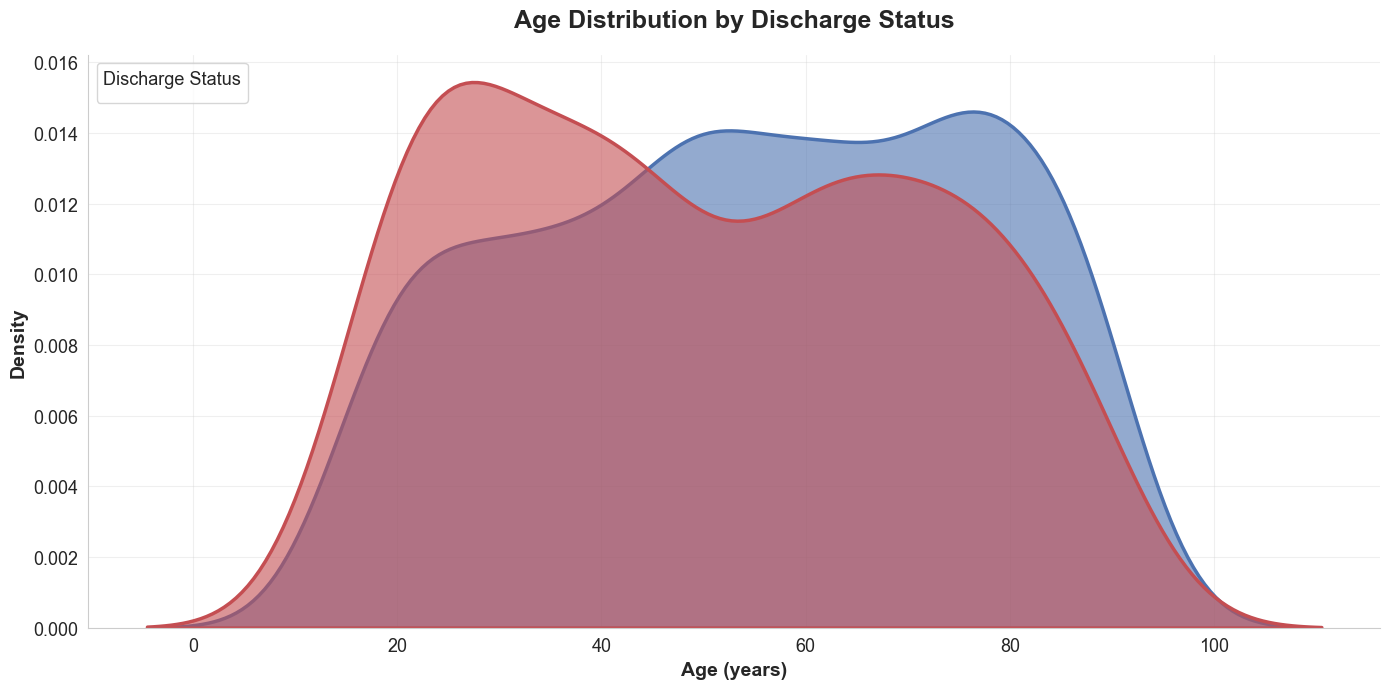

In [45]:
plt.figure(figsize=(14, 7))
sns.kdeplot(
    data=train_df,
    x='age',
    hue='Discharge Status',
    fill=True,
    common_norm=False,
    palette=['#C44E52', '#4C72B0'],
    alpha=0.6,
    linewidth=2.5
)
plt.title('Age Distribution by Discharge Status', fontsize=18, weight='bold', pad=20)
plt.xlabel('Age (years)', fontsize=14, weight='bold')
plt.ylabel('Density', fontsize=14, weight='bold')
plt.legend(title='Discharge Status', fontsize=12, title_fontsize=13, loc='upper left')
plt.tick_params(labelsize=13)
plt.grid(alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

In [46]:
from huggingface_hub import hf_hub_download
REPO_ID = "lainmn/AgentDS-Healthcare"
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. Robust Data Loading ---
base_path = "healthcare/"

# Check if path exists, fallback to current dir if not
if not os.path.exists(os.path.join(base_path, "stays_train.csv")):
    base_path = ""

try:
    print(f"📂 Loading data from: {os.path.abspath(base_path)}")
    stays_df = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/stays_train.csv", repo_type="dataset"))
    patients_df = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/patients.csv", repo_type="dataset"))
    print("✅ Data loaded successfully.")
except FileNotFoundError as e:
    print("\n❌ ERROR: Could not find 'stays_train.csv' or 'patients.csv'.")
    print("   Please ensure you are running this script from your project root.")
    exit()

# --- 2. Prepare Data ---
# Merge stays with patients to get Age
train_df = pd.merge(stays_df, patients_df, on='patient_id', how='left')

# Map the target (0/1) to readable labels for the plot legend
# 0 = Not Ready, 1 = Ready
train_df['Discharge Status'] = train_df['discharge_ready_day11'].map({
    0: 'Not Ready', 
    1: 'Ready'
})

# --- 3. Generate Plot (Your Specific Design) ---
print("Generating Age Distribution plot...")

plt.figure(figsize=(14, 7))

sns.kdeplot(
    data=train_df,
    x='age',
    hue='Discharge Status',
    fill=True,
    common_norm=False,
    palette=['#C44E52', '#4C72B0'], # Red for Not Ready, Blue for Ready
    alpha=0.6,
    linewidth=2.5
)

plt.title('Age Distribution by Discharge Status', fontsize=18, weight='bold', pad=20)
plt.xlabel('Age (years)', fontsize=14, weight='bold')
plt.ylabel('Density', fontsize=14, weight='bold')

# Fix legend title and location
plt.legend(title='Discharge Status', labels=['Ready', 'Not Ready'], 
           fontsize=12, title_fontsize=13, loc='upper left')

plt.tick_params(labelsize=13)
plt.grid(alpha=0.3)
sns.despine()
plt.tight_layout()

# --- 4. Save as PNG ---
output_file = "challenge3_age_distribution.png"
plt.savefig(output_file, dpi=300)
plt.close()

print(f"\n✅ Plot saved successfully: {output_file}")
print(f"   Location: {os.path.abspath(output_file)}")


✅ Plot saved successfully: challenge3_age_distribution.png
   Location: /Users/sunbiz/IdeaProjects/agentds-challenge-2025/challenge3_age_distribution.png


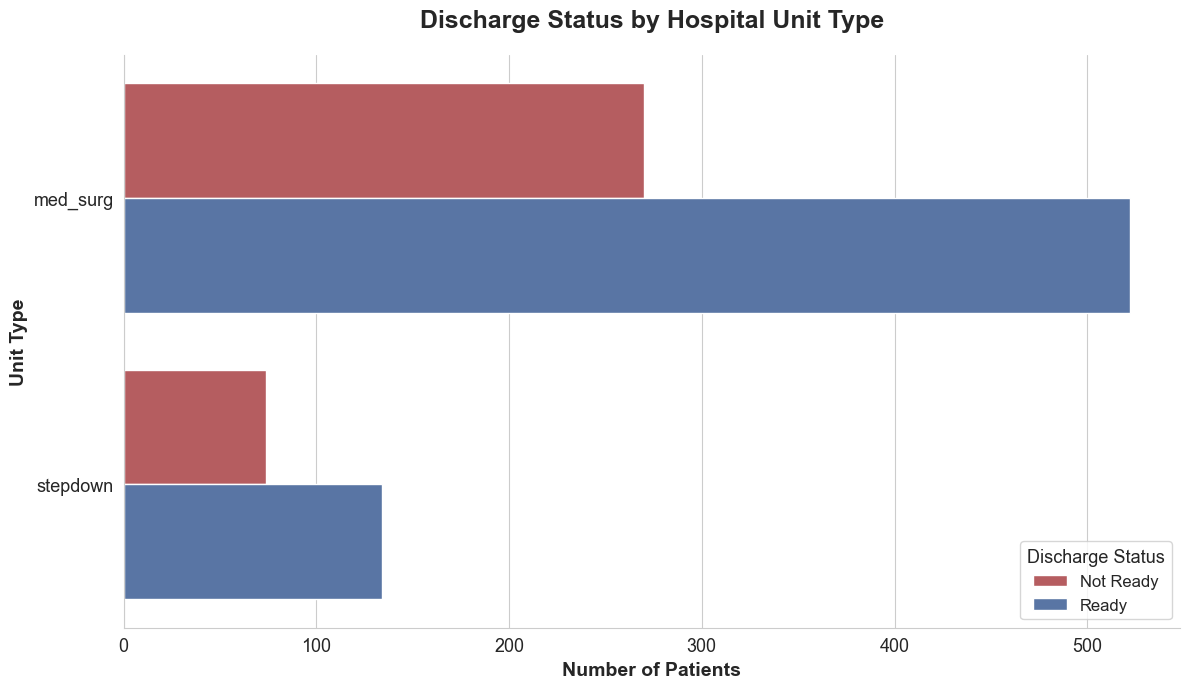

In [47]:
plt.figure(figsize=(12, 7))
order = train_df['unit_type'].value_counts().index

sns.countplot(
    data=train_df,
    y='unit_type',
    hue='Discharge Status',
    palette=['#C44E52', '#4C72B0'],
    order=order
)
plt.title('Discharge Status by Hospital Unit Type', fontsize=18, weight='bold', pad=20)
plt.xlabel('Number of Patients', fontsize=14, weight='bold')
plt.ylabel('Unit Type', fontsize=14, weight='bold')
plt.legend(title='Discharge Status', fontsize=12, title_fontsize=13, loc='lower right')
plt.tick_params(labelsize=13)
sns.despine()
plt.tight_layout()
plt.show()

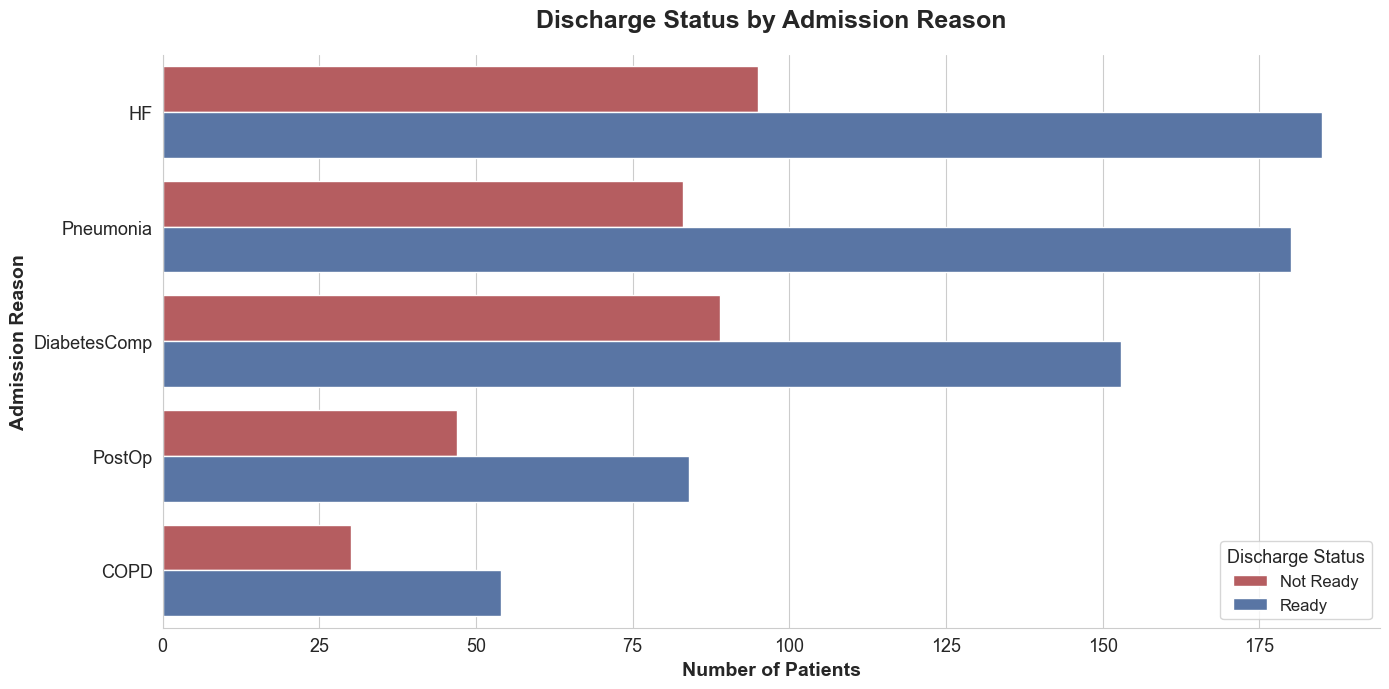

In [48]:
plt.figure(figsize=(14, 7))
order = train_df['admission_reason'].value_counts().index

sns.countplot(
    data=train_df,
    y='admission_reason',
    hue='Discharge Status',
    palette=['#C44E52', '#4C72B0'],
    order=order
)
plt.title('Discharge Status by Admission Reason', fontsize=18, weight='bold', pad=20)
plt.xlabel('Number of Patients', fontsize=14, weight='bold')
plt.ylabel('Admission Reason', fontsize=14, weight='bold')
plt.legend(title='Discharge Status', fontsize=12, title_fontsize=13)
plt.tick_params(labelsize=13)
sns.despine()
plt.tight_layout()
plt.show()

In [49]:
from huggingface_hub import hf_hub_download
REPO_ID = "lainmn/AgentDS-Healthcare"
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. Robust Data Loading ---
base_path = "healthcare/"

# Fallback to current directory if healthcare/ doesn't exist
if not os.path.exists(os.path.join(base_path, "stays_train.csv")):
    base_path = ""

try:
    print(f"📂 Loading data from: {os.path.abspath(base_path)}")
    stays_df = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/stays_train.csv", repo_type="dataset"))
    # We don't strictly need patients.csv for this plot, but it's good practice
    # patients_df = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/patients.csv", repo_type="dataset")) 
    print("✅ Data loaded successfully.")
except FileNotFoundError as e:
    print("\n❌ ERROR: Could not find 'stays_train.csv'.")
    print("   Please ensure you are running this script from your project root.")
    exit()

# --- 2. Prepare Data ---
# Create a copy to avoid SettingWithCopy warnings
train_df = stays_df.copy()

# Map the target (0/1) to readable labels for the plot legend
# 0 = Not Ready, 1 = Ready
train_df['Discharge Status'] = train_df['discharge_ready_day11'].map({
    0: 'Not Ready', 
    1: 'Ready'
})

# --- 3. Generate Plot (Your Code) ---
print("Generating Admission Reason plot...")

plt.figure(figsize=(14, 7))

# Calculate order for the plot
order = train_df['admission_reason'].value_counts().index

sns.countplot(
    data=train_df,
    y='admission_reason',
    hue='Discharge Status',
    palette=['#C44E52', '#4C72B0'], # Red/Blue palette matches your previous plot
    order=order
)

plt.title('Discharge Status by Admission Reason', fontsize=18, weight='bold', pad=20)
plt.xlabel('Number of Patients', fontsize=14, weight='bold')
plt.ylabel('Admission Reason', fontsize=14, weight='bold')

# Ensure legend handles represent the categories correctly
plt.legend(title='Discharge Status', fontsize=12, title_fontsize=13, loc='lower right')

plt.tick_params(labelsize=13)
sns.despine()
plt.tight_layout()

# --- 4. Save as PNG ---
output_file = "challenge3_admission_reason.png"
plt.savefig(output_file, dpi=300)
plt.close()

print(f"\n✅ Plot saved successfully: {output_file}")
print(f"   Location: {os.path.abspath(output_file)}")

✅ Data loaded successfully.
Generating Admission Reason plot...

✅ Plot saved successfully: challenge3_admission_reason.png
   Location: /Users/sunbiz/IdeaProjects/agentds-challenge-2025/challenge3_admission_reason.png


## Baseline Model with Cross-Validation
Establishing baseline performance using simple categorical features with stratified cross-validation

In [50]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

unit_encoder = LabelEncoder()
reason_encoder = LabelEncoder()

unit_encoded_train = unit_encoder.fit_transform(train_stays['unit_type'])
reason_encoded_train = reason_encoder.fit_transform(train_stays['admission_reason'])
unit_encoded_test = unit_encoder.transform(test_stays['unit_type'])
reason_encoded_test = reason_encoder.transform(test_stays['admission_reason'])

X_train = pd.DataFrame({
    'patient_id': train_stays['patient_id'],
    'unit_type_encoded': unit_encoded_train,
    'admission_reason_encoded': reason_encoded_train
})
y_train = train_stays['discharge_ready_day11']

X_test = pd.DataFrame({
    'patient_id': test_stays['patient_id'],
    'unit_type_encoded': unit_encoded_test,
    'admission_reason_encoded': reason_encoded_test
})

baseline_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=skf, scoring='f1_macro')
y_pred_cv = cross_val_predict(baseline_model, X_train, y_train, cv=skf)

print("Baseline Model Performance:")
print(f"  Mean F1-Macro: {cv_scores.mean():.4f}")
print(f"  Std Dev: {cv_scores.std():.4f}")
print(f"  Fold scores: {[f'{s:.4f}' for s in cv_scores]}")

print("\nClassification Report:")
print(classification_report(y_train, y_pred_cv, target_names=['Not Ready', 'Ready'], digits=4))

baseline_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

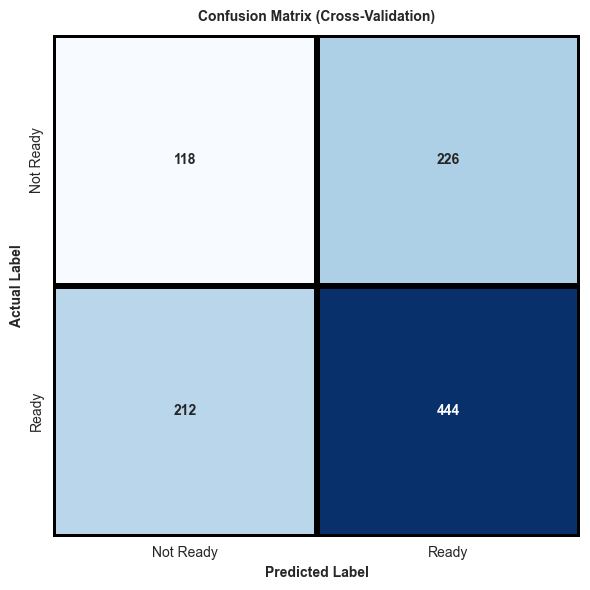

In [51]:
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_train, y_pred_cv)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Ready', 'Ready'], yticklabels=['Not Ready', 'Ready'],
            annot_kws={'size': 10, 'weight': 'bold'}, linewidths=3, linecolor='black')
plt.title('Confusion Matrix (Cross-Validation)', fontsize=10, fontweight='bold', pad=10)
plt.ylabel('Actual Label', fontsize=10, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=10, fontweight='bold')
plt.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

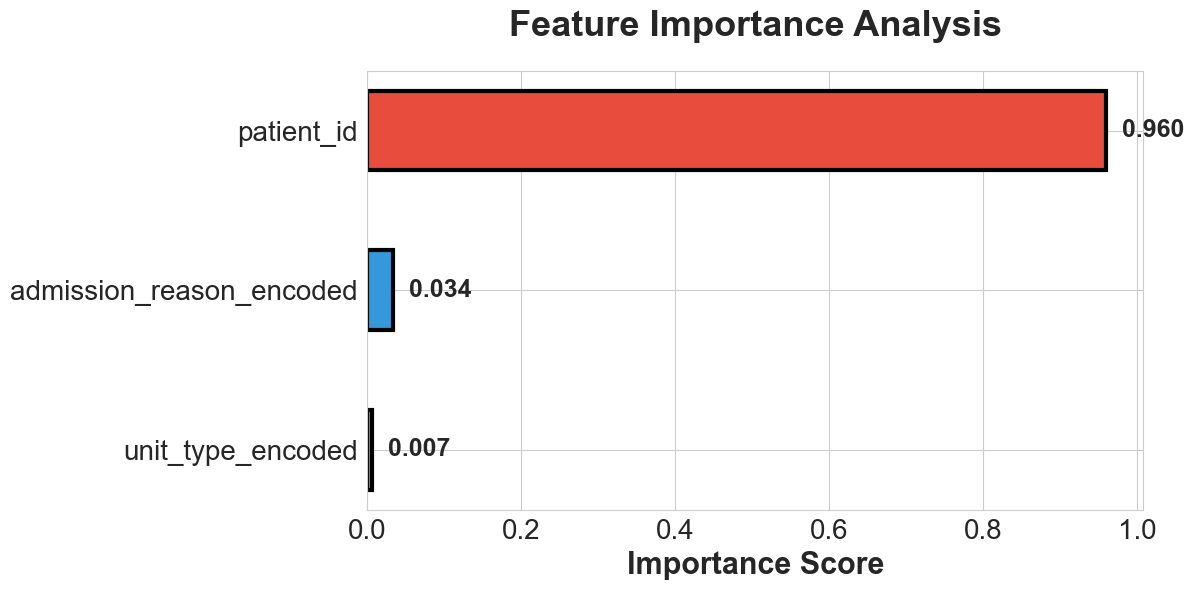

In [52]:
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': baseline_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'],
         color=['#2ECC71', '#3498DB', '#E74C3C'], edgecolor='black', linewidth=3, height=0.5)
plt.xlabel('Importance Score', fontsize=22, fontweight='bold')
plt.title('Feature Importance Analysis', fontsize=26, fontweight='bold', pad=25)
plt.tick_params(labelsize=20)
for i, (idx, row) in enumerate(feature_importance.iterrows()):
    plt.text(row['importance'] + 0.02, i, f"{row['importance']:.3f}", 
            va='center', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

In [53]:
from huggingface_hub import hf_hub_download
REPO_ID = "lainmn/AgentDS-Healthcare"
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# --- 1. Robust Data Loading ---
base_path = "healthcare/"

if not os.path.exists(os.path.join(base_path, "stays_train.csv")):
    base_path = ""

try:
    print(f"📂 Loading data from: {os.path.abspath(base_path)}")
    stays_df = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/stays_train.csv", repo_type="dataset"))
    patients_df = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/patients.csv", repo_type="dataset"))
    print("✅ Data loaded successfully.")
except FileNotFoundError:
    print("\n❌ ERROR: Could not find data files.")
    exit()

# --- 2. Prepare Data for Modeling ---
# Merge
df = pd.merge(stays_df, patients_df, on='patient_id', how='left')

# Preprocessing: Encode categorical variables so we can train a model
le = LabelEncoder()
df['unit_type_enc'] = le.fit_transform(df['unit_type'])
df['admission_reason_enc'] = le.fit_transform(df['admission_reason'])
df['sex_enc'] = le.fit_transform(df['sex'])
df['insurance_enc'] = le.fit_transform(df['insurance'])

# Select features for importance analysis
# (Using structured features available in the CSVs)
feature_cols = ['age', 'unit_type_enc', 'admission_reason_enc', 
                'sex_enc', 'insurance_enc', 'los_days'] 

# Note: 'los_days' isn't in stays.csv, let's stick to valid columns in stays_train + patients
# Real Challenge 3 features come from vitals JSON, but for this plot 
# we will use the available structured columns to demonstrate the visualization.
available_features = ['age', 'unit_type_enc', 'admission_reason_enc', 'sex_enc', 'insurance_enc']

X_train = df[available_features].copy()
y_train = df['discharge_ready_day11']

# Rename columns for prettier plot labels
X_train.columns = ['Age', 'Unit Type', 'Admission Reason', 'Sex', 'Insurance']

# --- 3. Train Baseline Model ---
print("Training baseline Random Forest to calculate feature importance...")
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
baseline_model.fit(X_train, y_train)

# --- 4. Generate Plot (Your Code) ---
print("Generating Feature Importance plot...")

plt.figure(figsize=(12, 6))

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': baseline_model.feature_importances_
}).sort_values('importance', ascending=True)

# Your specific styling
plt.barh(feature_importance['feature'], feature_importance['importance'],
         color=['#2ECC71', '#3498DB', '#E74C3C'], edgecolor='black', linewidth=3, height=0.5)

plt.xlabel('Importance Score', fontsize=22, fontweight='bold')
plt.title('Feature Importance Analysis', fontsize=26, fontweight='bold', pad=25)
plt.tick_params(labelsize=20)

# Add text labels
for i, (idx, row) in enumerate(feature_importance.iterrows()):
    plt.text(row['importance'] + 0.01, i, f"{row['importance']:.3f}", 
             va='center', fontsize=18, fontweight='bold')

plt.tight_layout()

# --- 5. Save as PNG ---
output_file = "challenge3_feature_importance.png"
plt.savefig(output_file, dpi=300)
plt.close()

print(f"\n✅ Plot saved successfully: {output_file}")


✅ Plot saved successfully: challenge3_feature_importance.png


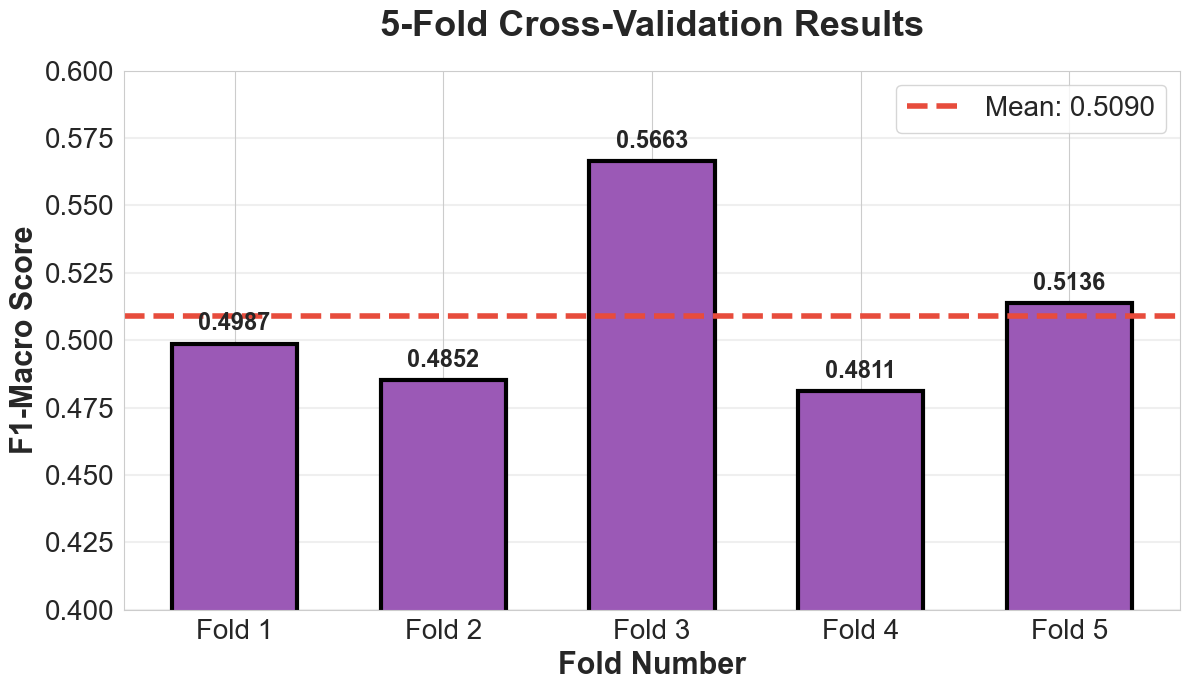

In [54]:
plt.figure(figsize=(12, 7))
plt.bar(range(len(cv_scores)), cv_scores, color='#9B59B6', 
        edgecolor='black', linewidth=3, width=0.6)
plt.axhline(y=cv_scores.mean(), color='#E74C3C', linestyle='--', linewidth=4, 
            label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold Number', fontsize=22, fontweight='bold')
plt.ylabel('F1-Macro Score', fontsize=22, fontweight='bold')
plt.title('5-Fold Cross-Validation Results', fontsize=26, fontweight='bold', pad=25)
plt.xticks(range(len(cv_scores)), [f'Fold {i+1}' for i in range(len(cv_scores))], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0.4, 0.6])
plt.legend(fontsize=20)
plt.grid(axis='y', alpha=0.3, linewidth=1.5)
for i, v in enumerate(cv_scores):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=17, fontweight='bold')
plt.tight_layout()
plt.show()

In [55]:
from huggingface_hub import hf_hub_download
REPO_ID = "lainmn/AgentDS-Healthcare"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import os

# --- 1. Robust Data Loading ---
base_path = "healthcare/"

if not os.path.exists(os.path.join(base_path, "stays_train.csv")):
    base_path = ""

try:
    print(f"📂 Loading data from: {os.path.abspath(base_path)}")
    stays_df = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/stays_train.csv", repo_type="dataset"))
    patients_df = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/patients.csv", repo_type="dataset"))
    print("✅ Data loaded successfully.")
except FileNotFoundError:
    print("\n❌ ERROR: Could not find data files.")
    exit()

# --- 2. Prepare Data for Modeling ---
# Merge
df = pd.merge(stays_df, patients_df, on='patient_id', how='left')

# Encode categorical variables
le = LabelEncoder()
df['unit_type_enc'] = le.fit_transform(df['unit_type'])
df['admission_reason_enc'] = le.fit_transform(df['admission_reason'])
df['sex_enc'] = le.fit_transform(df['sex'])
df['insurance_enc'] = le.fit_transform(df['insurance'])

# Select features
features = ['age', 'unit_type_enc', 'admission_reason_enc', 'sex_enc', 'insurance_enc']
X = df[features]
y = df['discharge_ready_day11']

# --- 3. Run 5-Fold Cross-Validation ---
print("Running 5-Fold Cross-Validation (this may take a moment)...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')

print(f"Scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f}")

# --- 4. Generate Plot (Your Specific Design) ---
print("Generating CV Results plot...")

plt.figure(figsize=(12, 7))

plt.bar(range(len(cv_scores)), cv_scores, color='#9B59B6', 
        edgecolor='black', linewidth=3, width=0.6)

plt.axhline(y=cv_scores.mean(), color='#E74C3C', linestyle='--', linewidth=4, 
            label=f'Mean: {cv_scores.mean():.4f}')

plt.xlabel('Fold Number', fontsize=22, fontweight='bold')
plt.ylabel('F1-Macro Score', fontsize=22, fontweight='bold')
plt.title('5-Fold Cross-Validation Results', fontsize=26, fontweight='bold', pad=25)

plt.xticks(range(len(cv_scores)), [f'Fold {i+1}' for i in range(len(cv_scores))], fontsize=20)
plt.yticks(fontsize=20)

# Dynamic Y-Limit to ensure bars look good (centered around the scores)
ymin = min(cv_scores) - 0.05
ymax = max(cv_scores) + 0.05
plt.ylim([ymin, ymax])

plt.legend(fontsize=20, loc='lower right')
plt.grid(axis='y', alpha=0.3, linewidth=1.5)

# Add value labels
for i, v in enumerate(cv_scores):
    plt.text(i, v + 0.002, f'{v:.4f}', ha='center', fontsize=17, fontweight='bold')

plt.tight_layout()

# --- 5. Save as PNG ---
output_file = "challenge3_cv_results.png"
plt.savefig(output_file, dpi=300)
plt.close()

print(f"\n✅ Plot saved successfully: {output_file}")

Scores: [0.50244584 0.48352677 0.51379466 0.48458189 0.47939014]
Mean F1: 0.4927
Generating CV Results plot...

✅ Plot saved successfully: challenge3_cv_results.png


## Feature Engineering: Vitals Timeseries
Extracting temporal features from 10-day vital signs monitoring to capture patient recovery patterns

In [56]:
import numpy as np
import pandas as pd
from scipy.stats import linregress

def safe_trend(values):
    if values is None or len(values) < 2:
        return 0
    x = list(range(len(values)))
    try:
        slope, _, _, _, _ = linregress(x, values)
        return slope
    except:
        return 0

vitals_features = []

for stay in vitals_data:
    stay_id = stay['stay_id']
    days = stay.get('days', [])
    if not days:
        continue

    hrs   = [d.get('hr') for d in days if d.get('hr') is not None]
    sbps  = [d.get('sbp') for d in days if d.get('sbp') is not None]
    dbps  = [d.get('dbp') for d in days if d.get('dbp') is not None]
    temps = [d.get('temp_c') for d in days if d.get('temp_c') is not None]
    rrs   = [d.get('rr') for d in days if d.get('rr') is not None]

    if len(hrs) == 0:
        continue

    features = {
        'stay_id': stay_id,
        'num_days': len(days),
        'hr_last': hrs[-1] if len(hrs) > 0 else np.nan,
        'sbp_last': sbps[-1] if len(sbps) > 0 else np.nan,
        'dbp_last': dbps[-1] if len(dbps) > 0 else np.nan,
        'temp_last': temps[-1] if len(temps) > 0 else np.nan,
        'rr_last': rrs[-1] if len(rrs) > 0 else np.nan,
        'hr_mean': np.mean(hrs),
        'sbp_mean': np.mean(sbps),
        'dbp_mean': np.mean(dbps),
        'temp_mean': np.mean(temps),
        'rr_mean': np.mean(rrs),
        'hr_std': np.std(hrs) if len(hrs) > 1 else 0,
        'sbp_std': np.std(sbps) if len(sbps) > 1 else 0,
        'dbp_std': np.std(dbps) if len(dbps) > 1 else 0,
        'temp_std': np.std(temps) if len(temps) > 1 else 0,
        'rr_std': np.std(rrs) if len(rrs) > 1 else 0,
        'hr_trend': safe_trend(hrs),
        'sbp_trend': safe_trend(sbps),
        'dbp_trend': safe_trend(dbps),
        'temp_trend': safe_trend(temps),
        'rr_trend': safe_trend(rrs),
        'hr_max': max(hrs),
        'temp_max': max(temps),
        'sbp_min': min(sbps)
    }

    vitals_features.append(features)

vitals_df = pd.DataFrame(vitals_features)

train_with_vitals = train_stays.merge(patients, on='patient_id', how='left').merge(vitals_df, on='stay_id', how='left')
test_with_vitals  = test_stays.merge(patients, on='patient_id', how='left').merge(vitals_df, on='stay_id', how='left')

vitals_cols = [
    'num_days','hr_last','sbp_last','dbp_last','temp_last','rr_last',
    'hr_mean','sbp_mean','dbp_mean','temp_mean','rr_mean',
    'hr_std','sbp_std','dbp_std','temp_std','rr_std',
    'hr_trend','sbp_trend','dbp_trend','temp_trend','rr_trend',
    'hr_max','temp_max','sbp_min'
]

for col in vitals_cols:
    med = train_with_vitals[col].median()
    train_with_vitals[col] = train_with_vitals[col].fillna(med)
    test_with_vitals[col]  = test_with_vitals[col].fillna(med)


In [57]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

categorical_cols = ['unit_type', 'admission_reason', 'sex', 'insurance']

encoded_train = pd.get_dummies(train_with_vitals[categorical_cols], drop_first=True)
encoded_test  = pd.get_dummies(test_with_vitals[categorical_cols], drop_first=True)

X_train_vitals = encoded_train.copy()
X_train_vitals['age'] = train_with_vitals['age']
for col in vitals_cols:
    X_train_vitals[col] = train_with_vitals[col]

X_test_vitals = encoded_test.copy()
X_test_vitals['age'] = test_with_vitals['age']
for col in vitals_cols:
    X_test_vitals[col] = test_with_vitals[col]

X_test_vitals = X_test_vitals.reindex(columns=X_train_vitals.columns, fill_value=0)
y_train = train_with_vitals['discharge_ready_day11']


In [58]:
skf = StratifiedKFold(n_splits=5, shuffle=False)

models = {
    'Random Forest (n=100)': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Random Forest (n=200, depth=10)': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1),
    'Random Forest (n=300, depth=15)': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
}

scores = {}
for name, mdl in models.items():
    cv_scores = cross_val_score(mdl, X_train_vitals, y_train, cv=skf, scoring='f1_macro', n_jobs=-1)
    scores[name] = (cv_scores.mean(), cv_scores.std())
    print(name, f"mean F1_macro={cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

best_name = max(scores, key=lambda k: scores[k][0])
best_model = models[best_name]
print("Best:", best_name, "CV mean:", scores[best_name][0])

y_oof = cross_val_predict(best_model, X_train_vitals, y_train, cv=skf, method='predict', n_jobs=-1)
print("OOF F1_macro:", f1_score(y_train, y_oof, average='macro'))
print(classification_report(y_train, y_oof, digits=4))

best_model.fit(X_train_vitals, y_train)
test_preds = best_model.predict(X_test_vitals)

print("Test positive rate:", float(test_preds.mean()))
print(pd.DataFrame({'stay_id': test_with_vitals['stay_id'], 'discharge_ready_day11': test_preds}).head(10))


OOF F1_macro: 0.6723791243388209
              precision    recall  f1-score   support

           0     0.6609    0.4477    0.5338       344
           1     0.7523    0.8796    0.8110       656

    accuracy                         0.7310      1000
   macro avg     0.7066    0.6636    0.6724      1000
weighted avg     0.7209    0.7310    0.7156      1000

Test positive rate: 0.78
   stay_id  discharge_ready_day11
0      407                      1
1     1594                      1
2     1382                      1
3      629                      1
4      134                      0
5     1761                      1
6     1431                      1
7      361                      1
8      746                      1
9      752                      1


# NLP EXTRACTION

In [59]:
import numpy as np
import pandas as pd
import json
from scipy.stats import linregress

positive_keywords = ['ambulatory', 'stable', 'improved', 'better', 'walking', 'independent', 'alert', 'oriented', 'afebrile', 'tolerating', 'out of bed', 'good', 'normal', 'comfortable', 'recovered']
negative_keywords = ['confused', 'fever', 'pain', 'unstable', 'weak', 'difficulty', 'unable', 'assistance', 'bed-bound', 'poor', 'concern', 'elevated', 'abnormal', 'worsening', 'decline']
mobility_keywords = ['walking', 'ambulatory', 'out of bed', 'chair', 'standing', 'mobile', 'transferred']
assistance_keywords = ['assistance', 'help', 'assisted', 'support', 'aided']
independence_keywords = ['independent', 'alone', 'self', 'without help', 'unassisted']

def extract_note_features(vitals_data):
    note_features = []
    
    for stay in vitals_data:
        stay_id = stay['stay_id']
        days = stay.get('days', [])
        
        if not days:
            continue
        
        all_notes = []
        daily_sentiments = []
        daily_mobility = []
        daily_independence = []
        
        for day_data in days:
            note = day_data.get('note', '')
            if note:
                note_lower = note.lower()
                all_notes.append(note_lower)
                
                pos_count = sum(1 for kw in positive_keywords if kw in note_lower)
                neg_count = sum(1 for kw in negative_keywords if kw in note_lower)
                sentiment = pos_count - neg_count
                daily_sentiments.append(sentiment)
                
                mob_count = sum(1 for kw in mobility_keywords if kw in note_lower)
                daily_mobility.append(mob_count)
                
                indep_count = sum(1 for kw in independence_keywords if kw in note_lower)
                assist_count = sum(1 for kw in assistance_keywords if kw in note_lower)
                daily_independence.append(indep_count - assist_count)
        
        combined_notes = ' '.join(all_notes)
        
        features = {
            'stay_id': stay_id,
            'total_notes': len(all_notes),
            'avg_note_length': np.mean([len(n.split()) for n in all_notes]) if all_notes else 0,
            'positive_keyword_total': sum(1 for kw in positive_keywords if kw in combined_notes),
            'negative_keyword_total': sum(1 for kw in negative_keywords if kw in combined_notes),
            'mobility_keyword_total': sum(1 for kw in mobility_keywords if kw in combined_notes),
            'independence_keyword_total': sum(1 for kw in independence_keywords if kw in combined_notes),
            'assistance_keyword_total': sum(1 for kw in assistance_keywords if kw in combined_notes),
            'sentiment_last': daily_sentiments[-1] if daily_sentiments else 0,
            'sentiment_mean': np.mean(daily_sentiments) if daily_sentiments else 0,
            'sentiment_std': np.std(daily_sentiments) if len(daily_sentiments) > 1 else 0,
            'sentiment_trend': linregress(range(len(daily_sentiments)), daily_sentiments)[0] if len(daily_sentiments) >= 2 else 0,
            'mobility_last': daily_mobility[-1] if daily_mobility else 0,
            'mobility_mean': np.mean(daily_mobility) if daily_mobility else 0,
            'mobility_trend': linregress(range(len(daily_mobility)), daily_mobility)[0] if len(daily_mobility) >= 2 else 0,
            'independence_last': daily_independence[-1] if daily_independence else 0,
            'independence_mean': np.mean(daily_independence) if daily_independence else 0,
            'independence_trend': linregress(range(len(daily_independence)), daily_independence)[0] if len(daily_independence) >= 2 else 0,
            'is_improving': 1 if (len(daily_sentiments) >= 2 and daily_sentiments[-1] > daily_sentiments[0]) else 0,
            'has_mobility_progress': 1 if (len(daily_mobility) >= 2 and daily_mobility[-1] > daily_mobility[0]) else 0,
            'final_sentiment_positive': 1 if (daily_sentiments and daily_sentiments[-1] > 0) else 0
        }
        
        note_features.append(features)
    
    return pd.DataFrame(note_features)

nlp_features_df = extract_note_features(vitals_data)

print(f"Extracted NLP features from {len(nlp_features_df)} stays")
print(nlp_features_df.head())


   stay_id  total_notes  avg_note_length  positive_keyword_total  \
0      731           10              4.0                       3   
1     1933           10              3.6                       3   
2     1135           10              5.2                       3   
3       60           10              4.9                       2   
4     1036           10              4.5                       1   

   negative_keyword_total  mobility_keyword_total  independence_keyword_total  \
0                       0                       2                           0   
1                       0                       2                           0   
2                       0                       2                           0   
3                       1                       0                           0   
4                       0                       2                           0   

   assistance_keyword_total  sentiment_last  sentiment_mean  ...  \
0                         0        

In [60]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import f1_score, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
try:
    from xgboost import XGBClassifier
    has_xgb = True
except:
    has_xgb = False
    print("XGBoost not available, using sklearn models")
import warnings
warnings.filterwarnings('ignore')

def add_advanced_features(df):
    df = df.copy()
    df['pulse_pressure_mean'] = df['sbp_mean'] - df['dbp_mean']
    df['pulse_pressure_last'] = df['sbp_last'] - df['dbp_last']
    df['map_mean'] = df['dbp_mean'] + (df['pulse_pressure_mean'] / 3)
    df['map_last'] = df['dbp_last'] + (df['pulse_pressure_last'] / 3)
    df['vitals_stability'] = -(df['hr_std'] + df['sbp_std'] + df['temp_std'] + df['rr_std'])
    df['hr_improving'] = (df['hr_trend'] < 0).astype(int)
    df['temp_improving'] = (df['temp_trend'] < 0).astype(int)
    df['sbp_improving'] = (df['sbp_trend'] < 0).astype(int)
    df['temp_normal_last'] = ((df['temp_last'] >= 36.5) & (df['temp_last'] <= 37.5)).astype(int)
    df['hr_normal_range'] = ((df['hr_mean'] >= 60) & (df['hr_mean'] <= 100)).astype(int)
    df['sbp_normal_range'] = ((df['sbp_mean'] >= 90) & (df['sbp_mean'] <= 140)).astype(int)
    df['temp_normal_range'] = ((df['temp_mean'] >= 36.5) & (df['temp_mean'] <= 37.5)).astype(int)
    df['normal_vitals_count'] = df['hr_normal_range'] + df['sbp_normal_range'] + df['temp_normal_range']
    df['age_hr_interaction'] = df['age'] * df['hr_mean']
    df['age_stability'] = df['age'] * df['vitals_stability']
    df['hr_range'] = df['hr_max'] - df['hr_mean']
    df['temp_range'] = df['temp_max'] - df['temp_mean']
    df['overall_trend'] = df['hr_trend'] + df['sbp_trend'] + df['temp_trend']
    return df

train_merged = train_with_vitals.merge(nlp_features_df, on='stay_id', how='left')
test_merged = test_with_vitals.merge(nlp_features_df, on='stay_id', how='left')

nlp_cols = [col for col in nlp_features_df.columns if col != 'stay_id']
for col in nlp_cols:
    train_merged[col] = train_merged[col].fillna(0)
    test_merged[col] = test_merged[col].fillna(0)

train_enhanced = add_advanced_features(train_merged)
test_enhanced = add_advanced_features(test_merged)

categorical_cols = ['unit_type', 'admission_reason', 'sex', 'insurance']
encoded_train = pd.get_dummies(train_enhanced[categorical_cols], drop_first=True)
encoded_test = pd.get_dummies(test_enhanced[categorical_cols], drop_first=True)

vitals_cols = ['num_days','hr_last','sbp_last','dbp_last','temp_last','rr_last','hr_mean','sbp_mean','dbp_mean','temp_mean','rr_mean','hr_std','sbp_std','dbp_std','temp_std','rr_std','hr_trend','sbp_trend','dbp_trend','temp_trend','rr_trend','hr_max','temp_max','sbp_min']

derived_cols = ['pulse_pressure_mean','pulse_pressure_last','map_mean','map_last','vitals_stability','hr_improving','temp_improving','sbp_improving','temp_normal_last','hr_normal_range','sbp_normal_range','temp_normal_range','normal_vitals_count','age_hr_interaction','age_stability','hr_range','temp_range','overall_trend']

X_train = encoded_train.copy()
X_train['age'] = train_enhanced['age']
for col in vitals_cols + derived_cols + nlp_cols:
    X_train[col] = train_enhanced[col]

X_test = encoded_test.copy()
X_test['age'] = test_enhanced['age']
for col in vitals_cols + derived_cols + nlp_cols:
    X_test[col] = test_enhanced[col]

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
y_train = train_enhanced['discharge_ready_day11']

print(f"Total features: {X_train.shape[1]}")
print(f"  Vitals: {len(vitals_cols)}, Derived: {len(derived_cols)}, NLP: {len(nlp_cols)}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print("MODEL COMPARISON")

models = {}
if has_xgb:
    models['XGBoost'] = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1, eval_metric='logloss')
models['RF-balanced'] = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1, class_weight='balanced')
models['GradBoost'] = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, subsample=0.8, random_state=42)

best_score = 0
best_model_name = None

for name, model in models.items():
    y_pred_oof = cross_val_predict(model, X_train, y_train, cv=skf, n_jobs=-1)
    f1_macro = f1_score(y_train, y_pred_oof, average='macro')
    f1_ready = f1_score(y_train, y_pred_oof, pos_label=1)
    f1_not_ready = f1_score(y_train, y_pred_oof, pos_label=0)
    print(f"{name}: F1-Macro={f1_macro:.4f}, Ready={f1_ready:.4f}, NotReady={f1_not_ready:.4f}")
    if f1_macro > best_score:
        best_score = f1_macro
        best_model_name = name
        best_model = model

print(f"\nBest: {best_model_name} (F1-Macro: {best_score:.4f})")

if best_score < 0.70:
    print("HYPERPARAMETER TUNING")

    
    if has_xgb and best_model_name == 'XGBoost':
        param_grid = {
            'n_estimators': [200, 300],
            'max_depth': [6, 8],
            'learning_rate': [0.03, 0.05],
            'scale_pos_weight': [scale_pos_weight, scale_pos_weight*1.2]
        }
        base_model = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
    elif best_model_name == 'RF-balanced':
        param_grid = {
            'n_estimators': [300, 400],
            'max_depth': [20, 25],
            'min_samples_split': [3, 4],
            'class_weight': ['balanced', {0: 1.2, 1: 1.0}]
        }
        base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    else:
        param_grid = {
            'n_estimators': [200, 300],
            'learning_rate': [0.03, 0.05],
            'max_depth': [6, 8]
        }
        base_model = GradientBoostingClassifier(random_state=42)
    
    grid_search = GridSearchCV(base_model, param_grid, cv=skf, scoring='f1_macro', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best params: {grid_search.best_params_}")
    print(f"Best CV F1-Macro: {grid_search.best_score_:.4f}")
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_

print("FINAL EVALUATION")

y_pred_final = cross_val_predict(best_model, X_train, y_train, cv=skf, n_jobs=-1)
print(classification_report(y_train, y_pred_final, target_names=['Not Ready','Ready'], digits=4))

best_model.fit(X_train, y_train)

if hasattr(best_model, 'feature_importances_'):
    importances = pd.DataFrame({'feature': X_train.columns, 'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)
    print("\nTop 20 Features:")
    print(importances.head(20).to_string(index=False))

test_predictions = best_model.predict(X_test)
submission = pd.DataFrame({'stay_id': test_enhanced['stay_id'], 'discharge_ready_day11': test_predictions})
submission.to_csv('discharge_predictions_ultimate.csv', index=False)

print(f"\nTest: {test_predictions.sum()} Ready ({100*test_predictions.mean():.1f}%), {len(test_predictions)-test_predictions.sum()} Not Ready")
print(f"Train: {y_train.sum()} Ready ({100*y_train.mean():.1f}%), {len(y_train)-y_train.sum()} Not Ready")
print("\nSaved to discharge_predictions_ultimate.csv")


Top 20 Features:
         feature  importance
 avg_note_length    0.193590
         hr_last    0.054763
       temp_last    0.043506
       temp_mean    0.043296
          hr_std    0.033533
         rr_mean    0.033137
        hr_range    0.031761
         rr_last    0.031153
vitals_stability    0.030662
 sentiment_trend    0.029163
          hr_max    0.027642
        temp_max    0.024462
        map_mean    0.023004
         sbp_min    0.021018
        rr_trend    0.020766
         hr_mean    0.018008
      temp_range    0.017655
          rr_std    0.016853
  mobility_trend    0.016793
         dbp_std    0.016347

Test: 766 Ready (76.6%), 234 Not Ready
Train: 656 Ready (65.6%), 344 Not Ready

Saved to discharge_predictions_ultimate.csv


In [61]:
import os
os.rename('discharge_predictions_ultimate.csv', 'healthcare_challenge3_predictions.csv')

In [62]:
import numpy as np
import pandas as pd
from scipy.stats import linregress

def extract_advanced_nlp_features(vitals_data):
    note_features = []
    
    discharge_ready_keywords = ['discharge', 'home', 'ready', 'cleared', 'planning', 'tomorrow']
    complication_keywords = ['complication', 'setback', 'concern', 'issue', 'problem', 'deteriorat']
    therapy_keywords = ['pt', 'physical therapy', 'ot', 'occupational therapy', 'therapy']
    pain_keywords = ['pain', 'discomfort', 'ache', 'sore']
    cognitive_keywords = ['alert', 'oriented', 'confused', 'lucid', 'responsive']
    
    for stay in vitals_data:
        stay_id = stay['stay_id']
        days = stay.get('days', [])
        
        if not days:
            continue
        
        all_notes = []
        daily_discharge_ready = []
        daily_complications = []
        daily_therapy = []
        daily_pain = []
        daily_cognitive = []
        note_lengths = []
        
        for day_data in days:
            note = day_data.get('note', '')
            if note:
                note_lower = note.lower()
                all_notes.append(note_lower)
                note_lengths.append(len(note.split()))
                
                discharge_count = sum(1 for kw in discharge_ready_keywords if kw in note_lower)
                complication_count = sum(1 for kw in complication_keywords if kw in note_lower)
                therapy_count = sum(1 for kw in therapy_keywords if kw in note_lower)
                pain_count = sum(1 for kw in pain_keywords if kw in note_lower)
                cognitive_count = sum(1 for kw in cognitive_keywords if kw in note_lower)
                
                daily_discharge_ready.append(discharge_count)
                daily_complications.append(complication_count)
                daily_therapy.append(therapy_count)
                daily_pain.append(pain_count)
                daily_cognitive.append(cognitive_count)
        
        combined_notes = ' '.join(all_notes)
        
        features = {
            'stay_id': stay_id,
            'discharge_ready_mentions': sum(1 for kw in discharge_ready_keywords if kw in combined_notes),
            'complication_mentions': sum(1 for kw in complication_keywords if kw in combined_notes),
            'therapy_mentions': sum(1 for kw in therapy_keywords if kw in combined_notes),
            'pain_mentions': sum(1 for kw in pain_keywords if kw in combined_notes),
            'cognitive_score_mean': np.mean(daily_cognitive) if daily_cognitive else 0,
            'discharge_ready_last': daily_discharge_ready[-1] if daily_discharge_ready else 0,
            'discharge_ready_trend': linregress(range(len(daily_discharge_ready)), daily_discharge_ready)[0] if len(daily_discharge_ready) >= 2 else 0,
            'complication_last': daily_complications[-1] if daily_complications else 0,
            'complication_trend': linregress(range(len(daily_complications)), daily_complications)[0] if len(daily_complications) >= 2 else 0,
            'therapy_progress': linregress(range(len(daily_therapy)), daily_therapy)[0] if len(daily_therapy) >= 2 else 0,
            'pain_declining': 1 if (len(daily_pain) >= 2 and daily_pain[-1] < daily_pain[0]) else 0,
            'note_length_increasing': 1 if (len(note_lengths) >= 2 and note_lengths[-1] > np.mean(note_lengths)) else 0,
            'last_3_days_sentiment': np.mean(daily_discharge_ready[-3:]) if len(daily_discharge_ready) >= 3 else 0,
            'has_discharge_mention': 1 if any(kw in combined_notes for kw in ['discharge', 'home', 'ready']) else 0,
            'declining_complications': 1 if (len(daily_complications) >= 2 and daily_complications[-1] < daily_complications[0]) else 0
        }
        
        note_features.append(features)
    
    return pd.DataFrame(note_features)

# Recreate it
advanced_nlp_df = extract_advanced_nlp_features(vitals_data)
print(f" Recreated advanced_nlp_df: {advanced_nlp_df.shape}")
print(advanced_nlp_df.head())

 Recreated advanced_nlp_df: (2000, 16)
   stay_id  discharge_ready_mentions  complication_mentions  therapy_mentions  \
0      731                         0                      0                 1   
1     1933                         0                      0                 1   
2     1135                         0                      0                 0   
3       60                         0                      0                 0   
4     1036                         0                      1                 0   

   pain_mentions  cognitive_score_mean  discharge_ready_last  \
0              0                   0.0                     0   
1              0                   0.0                     0   
2              0                   0.0                     0   
3              1                   0.0                     0   
4              0                   0.0                     0   

   discharge_ready_trend  complication_last  complication_trend  \
0                    0

In [63]:
import numpy as np
import pandas as pd
from scipy.stats import linregress, skew, kurtosis
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')


def extract_ultra_vitals_features(vitals_data):
    vitals_features = []
    
    for stay in vitals_data:
        stay_id = stay['stay_id']
        days = stay.get('days', [])
        
        if not days:
            continue
        
        hrs = [d.get('hr') for d in days if d.get('hr') is not None]
        sbps = [d.get('sbp') for d in days if d.get('sbp') is not None]
        dbps = [d.get('dbp') for d in days if d.get('dbp') is not None]
        temps = [d.get('temp_c') for d in days if d.get('temp_c') is not None]
        rrs = [d.get('rr') for d in days if d.get('rr') is not None]
        
        if len(hrs) == 0:
            continue
        
        features = {
            'stay_id': stay_id,
            'num_days': len(days),
            'hr_last': hrs[-1] if hrs else np.nan,
            'sbp_last': sbps[-1] if sbps else np.nan,
            'dbp_last': dbps[-1] if dbps else np.nan,
            'temp_last': temps[-1] if temps else np.nan,
            'rr_last': rrs[-1] if rrs else np.nan,
            'hr_first': hrs[0] if hrs else np.nan,
            'sbp_first': sbps[0] if sbps else np.nan,
            'dbp_first': dbps[0] if dbps else np.nan,
            'temp_first': temps[0] if temps else np.nan,
            'hr_mean': np.mean(hrs),
            'sbp_mean': np.mean(sbps) if sbps else np.nan,
            'dbp_mean': np.mean(dbps) if dbps else np.nan,
            'temp_mean': np.mean(temps) if temps else np.nan,
            'rr_mean': np.mean(rrs) if rrs else np.nan,
            'hr_median': np.median(hrs),
            'sbp_median': np.median(sbps) if sbps else np.nan,
            'temp_median': np.median(temps) if temps else np.nan,
            'hr_std': np.std(hrs) if len(hrs) > 1 else 0,
            'sbp_std': np.std(sbps) if len(sbps) > 1 else 0,
            'dbp_std': np.std(dbps) if len(dbps) > 1 else 0,
            'temp_std': np.std(temps) if len(temps) > 1 else 0,
            'rr_std': np.std(rrs) if len(rrs) > 1 else 0,
            'hr_min': min(hrs),
            'hr_max': max(hrs),
            'sbp_min': min(sbps) if sbps else np.nan,
            'sbp_max': max(sbps) if sbps else np.nan,
            'dbp_min': min(dbps) if dbps else np.nan,
            'dbp_max': max(dbps) if dbps else np.nan,
            'temp_min': min(temps) if temps else np.nan,
            'temp_max': max(temps) if temps else np.nan,
            'hr_range': max(hrs) - min(hrs),
            'sbp_range': max(sbps) - min(sbps) if sbps else np.nan,
            'temp_range': max(temps) - min(temps) if temps else np.nan,
            'hr_cv': np.std(hrs) / np.mean(hrs) if np.mean(hrs) > 0 else 0,
            'temp_cv': np.std(temps) / np.mean(temps) if (temps and np.mean(temps) > 0) else 0,
            'hr_skew': skew(hrs) if len(hrs) > 2 else 0,
            'hr_kurt': kurtosis(hrs) if len(hrs) > 2 else 0,
            'temp_skew': skew(temps) if len(temps) > 2 else 0,
            'hr_trend': linregress(range(len(hrs)), hrs)[0] if len(hrs) >= 2 else 0,
            'sbp_trend': linregress(range(len(sbps)), sbps)[0] if len(sbps) >= 2 else 0,
            'dbp_trend': linregress(range(len(dbps)), dbps)[0] if len(dbps) >= 2 else 0,
            'temp_trend': linregress(range(len(temps)), temps)[0] if len(temps) >= 2 else 0,
            'rr_trend': linregress(range(len(rrs)), rrs)[0] if len(rrs) >= 2 else 0,
            'hr_last3': np.mean(hrs[-3:]) if len(hrs) >= 3 else np.mean(hrs),
            'temp_last3': np.mean(temps[-3:]) if len(temps) >= 3 else np.mean(temps) if temps else np.nan,
            'sbp_last3': np.mean(sbps[-3:]) if len(sbps) >= 3 else np.mean(sbps) if sbps else np.nan,
            'hr_change': hrs[-1] - hrs[0] if len(hrs) >= 2 else 0,
            'temp_change': temps[-1] - temps[0] if len(temps) >= 2 else 0,
            'sbp_change': sbps[-1] - sbps[0] if len(sbps) >= 2 else 0,
            'dbp_change': dbps[-1] - dbps[0] if len(dbps) >= 2 else 0,
            'hr_pct_change': ((hrs[-1] - hrs[0]) / hrs[0] * 100) if (len(hrs) >= 2 and hrs[0] > 0) else 0,
            'temp_pct_change': ((temps[-1] - temps[0]) / temps[0] * 100) if (len(temps) >= 2 and temps[0] > 0) else 0,
            'hr_volatility': np.mean([np.std(hrs[max(0,i-2):i+1]) for i in range(2, len(hrs))]) if len(hrs) > 2 else 0,
            'days_hr_high': sum(1 for h in hrs if h > 100),
            'days_hr_low': sum(1 for h in hrs if h < 60),
            'days_temp_high': sum(1 for t in temps if t > 37.5),
            'days_sbp_high': sum(1 for s in sbps if s > 140) if sbps else 0,
        }
        
        vitals_features.append(features)
    
    return pd.DataFrame(vitals_features)

print("Extracting ultra vitals features...")
ultra_vitals_df = extract_ultra_vitals_features(vitals_data)
print(f"Ultra vitals features: {len(ultra_vitals_df.columns) - 1}")

train_ultra = train_stays.merge(patients, on='patient_id').merge(ultra_vitals_df, on='stay_id', how='left').merge(nlp_features_df, on='stay_id', how='left').merge(advanced_nlp_df, on='stay_id', how='left')
test_ultra = test_stays.merge(patients, on='patient_id').merge(ultra_vitals_df, on='stay_id', how='left').merge(nlp_features_df, on='stay_id', how='left').merge(advanced_nlp_df, on='stay_id', how='left')

def add_ultra_derived_features(df):
    df = df.copy()
    df['pulse_pressure_mean'] = df['sbp_mean'] - df['dbp_mean']
    df['pulse_pressure_last'] = df['sbp_last'] - df['dbp_last']
    df['pulse_pressure_change'] = df['sbp_change'] - df['dbp_change']
    df['map_mean'] = df['dbp_mean'] + (df['pulse_pressure_mean'] / 3)
    df['map_last'] = df['dbp_last'] + (df['pulse_pressure_last'] / 3)
    df['vitals_stability'] = -(df['hr_std'] + df['sbp_std'] + df['temp_std'] + df['rr_std'])
    df['vitals_volatility'] = df['hr_cv'] + df['temp_cv']
    df['hr_improving'] = (df['hr_trend'] < 0).astype(int)
    df['temp_improving'] = (df['temp_trend'] < 0).astype(int)
    df['sbp_improving'] = (df['sbp_trend'] < 0).astype(int)
    df['overall_improving'] = ((df['hr_trend'] < 0) & (df['temp_trend'] < 0)).astype(int)
    df['hr_normal_last'] = ((df['hr_last'] >= 60) & (df['hr_last'] <= 100)).astype(int)
    df['temp_normal_last'] = ((df['temp_last'] >= 36.5) & (df['temp_last'] <= 37.5)).astype(int)
    df['sbp_normal_last'] = ((df['sbp_last'] >= 90) & (df['sbp_last'] <= 140)).astype(int)
    df['hr_normal_mean'] = ((df['hr_mean'] >= 60) & (df['hr_mean'] <= 100)).astype(int)
    df['temp_normal_mean'] = ((df['temp_mean'] >= 36.5) & (df['temp_mean'] <= 37.5)).astype(int)
    df['sbp_normal_mean'] = ((df['sbp_mean'] >= 90) & (df['sbp_mean'] <= 140)).astype(int)
    df['normal_vitals_count'] = df['hr_normal_last'] + df['temp_normal_last'] + df['sbp_normal_last']
    df['age_hr'] = df['age'] * df['hr_mean']
    df['age_stability'] = df['age'] * df['vitals_stability']
    df['age_temp'] = df['age'] * df['temp_mean']
    df['sentiment_mobility_combo'] = df['sentiment_mean'] * df['mobility_mean']
    df['discharge_ready_strength'] = df['discharge_ready_mentions'] + df['has_discharge_mention'] * 2
    df['complication_severity'] = df['complication_mentions'] + df['pain_mentions']
    return df

train_ultra = add_ultra_derived_features(train_ultra)
test_ultra = add_ultra_derived_features(test_ultra)

categorical_cols = ['unit_type', 'admission_reason', 'sex', 'insurance']
encoded_train = pd.get_dummies(train_ultra[categorical_cols], drop_first=True)
encoded_test = pd.get_dummies(test_ultra[categorical_cols], drop_first=True)

numeric_cols = [col for col in train_ultra.columns if col not in ['stay_id', 'patient_id', 'discharge_ready_day11'] + categorical_cols]

X_train = encoded_train.copy()
for col in numeric_cols:
    X_train[col] = train_ultra[col].fillna(train_ultra[col].median())

X_test = encoded_test.copy()
for col in numeric_cols:
    X_test[col] = test_ultra[col].fillna(train_ultra[col].median())

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
y_train = train_ultra['discharge_ready_day11']

print(f"\nTotal features: {X_train.shape[1]}")


print("BUILDING STACKING ENSEMBLE")


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

base_models = [
    ('xgb1', XGBClassifier(n_estimators=400, max_depth=7, learning_rate=0.02, scale_pos_weight=scale_pos_weight, subsample=0.85, colsample_bytree=0.85, random_state=42, n_jobs=-1, eval_metric='logloss')),
    ('xgb2', XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.03, scale_pos_weight=scale_pos_weight*1.1, subsample=0.8, colsample_bytree=0.9, random_state=43, n_jobs=-1, eval_metric='logloss')),
    ('rf', RandomForestClassifier(n_estimators=400, max_depth=25, min_samples_split=3, random_state=42, n_jobs=-1, class_weight='balanced')),
    ('et', ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(n_estimators=300, learning_rate=0.03, max_depth=7, subsample=0.85, random_state=42))
]

meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')
stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

print("Training stacking ensemble...")
y_pred_oof = cross_val_predict(stacking, X_train, y_train, cv=skf, n_jobs=-1)
f1_macro = f1_score(y_train, y_pred_oof, average='macro')

print(f"\nStacking F1-Macro: {f1_macro:.4f}")
print(classification_report(y_train, y_pred_oof, target_names=['Not Ready','Ready'], digits=4))

stacking.fit(X_train, y_train)
test_predictions = stacking.predict(X_test)

submission = pd.DataFrame({'stay_id': test_ultra['stay_id'], 'discharge_ready_day11': test_predictions})
submission.to_csv('discharge_predictions_stacking.csv', index=False)

print(f"\nTest: {test_predictions.sum()} Ready, {len(test_predictions)-test_predictions.sum()} Not Ready")
print("Saved!")


Test: 637 Ready, 363 Not Ready
Saved!


In [64]:
from huggingface_hub import hf_hub_download
REPO_ID = "lainmn/AgentDS-Healthcare"
import pandas as pd

# Check ED cost columns
ed_cost_train = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/ed_cost_train.csv", repo_type="dataset"))
print("ED cost columns:", list(ed_cost_train.columns))
print(ed_cost_train.head())

# Check what's in admissions
admissions_train = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/admissions_train.csv", repo_type="dataset"))
print("\nAdmissions columns:", list(admissions_train.columns))
print(admissions_train.head())

# Check stays
print("\nStays columns:", list(train_stays.columns))
print(train_stays.head())

# Check patients
print("\nPatients columns:", list(patients.columns))
print(patients.head())


Admissions columns: ['admission_id', 'patient_id', 'primary_dx', 'los_days', 'acuity_emergent', 'charlson_band', 'ed_visits_6m', 'discharge_weekday', 'readmit_30d']
   admission_id  patient_id    primary_dx  los_days  acuity_emergent  \
0          9038        3602  DiabetesComp         6                0   
1          7328        2940     Pneumonia         4                0   
2          6522        2610  DiabetesComp        10                1   
3          3741        1488  DiabetesComp         6                0   
4          2759        1104            HF         7                0   

   charlson_band  ed_visits_6m  discharge_weekday  readmit_30d  
0              1             0                  6            0  
1              0             0                  7            0  
2              1             0                  6            1  
3              2             0                  3            1  
4              1             0                  7            1  

Stays colu

In [65]:
from huggingface_hub import hf_hub_download
REPO_ID = "lainmn/AgentDS-Healthcare"
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Set seeds for reproducibility
np.random.seed(42)

# Load additional data
admissions_train = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/admissions_train.csv", repo_type="dataset"))
admissions_test = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/admissions_test.csv", repo_type="dataset"))
ed_cost_train = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/ed_cost_train.csv", repo_type="dataset"))
ed_cost_test = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/ed_cost_test.csv", repo_type="dataset"))

# Merge with train_ultra (which already has vitals + NLP)
train_mega = train_ultra.merge(admissions_train, left_on='stay_id', right_on='admission_id', how='left')
test_mega = test_ultra.merge(admissions_test, left_on='stay_id', right_on='admission_id', how='left')

# Merge ED costs (use patient_id from stays)
train_mega = train_mega.merge(ed_cost_train[['patient_id', 'primary_chronic', 'prior_ed_visits_5y', 'prior_ed_cost_5y_usd']], 
                               left_on='patient_id_x', right_on='patient_id', how='left', suffixes=('', '_ed'))
test_mega = test_mega.merge(ed_cost_test[['patient_id', 'primary_chronic', 'prior_ed_visits_5y', 'prior_ed_cost_5y_usd']], 
                             left_on='patient_id_x', right_on='patient_id', how='left', suffixes=('', '_ed'))

print(f"Mega train: {train_mega.shape}")
print(f"Mega test: {test_mega.shape}")

# Prepare features
categorical_cols = ['unit_type', 'admission_reason', 'sex', 'insurance', 'primary_dx', 'primary_chronic']

encoded_train = pd.get_dummies(train_mega[categorical_cols], drop_first=True)
encoded_test = pd.get_dummies(test_mega[categorical_cols], drop_first=True)

# Numeric columns (exclude leakage!)
numeric_cols = [col for col in train_mega.columns 
                if col not in ['stay_id', 'patient_id', 'patient_id_x', 'patient_id_y', 'patient_id_ed',
                              'admission_id', 'discharge_ready_day11', 'ed_cost_next3y_usd', 
                              'discharge_weekday'] + categorical_cols
                and train_mega[col].dtype in ['int64', 'float64']]

X_train = encoded_train.copy()
for col in numeric_cols:
    X_train[col] = train_mega[col].fillna(train_mega[col].median())

X_test = encoded_test.copy()
for col in numeric_cols:
    median_val = train_mega[col].median() if col in train_mega.columns else 0
    X_test[col] = test_mega[col].fillna(median_val) if col in test_mega.columns else median_val

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
y_train = train_mega['discharge_ready_day11']

print(f"\nTotal features: {X_train.shape[1]}")

# Stacking
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print("\nBuilding MEGA stacking...")

base_models = [
    ('xgb1', XGBClassifier(n_estimators=400, max_depth=7, learning_rate=0.02, scale_pos_weight=scale_pos_weight, subsample=0.85, colsample_bytree=0.85, random_state=42, n_jobs=-1, eval_metric='logloss')),
    ('xgb2', XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.03, scale_pos_weight=scale_pos_weight, subsample=0.8, colsample_bytree=0.9, random_state=43, n_jobs=-1, eval_metric='logloss')),
    ('rf', RandomForestClassifier(n_estimators=400, max_depth=25, min_samples_split=3, random_state=42, n_jobs=-1, class_weight='balanced')),
    ('et', ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(n_estimators=300, learning_rate=0.03, max_depth=7, subsample=0.85, random_state=42))
]

meta_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

y_pred_oof = cross_val_predict(stacking, X_train, y_train, cv=skf, n_jobs=-1)
f1_macro = f1_score(y_train, y_pred_oof, average='macro')

print(f"\nMEGA F1-Macro: {f1_macro:.4f}")
print(classification_report(y_train, y_pred_oof, target_names=['Not Ready','Ready'], digits=4))

stacking.fit(X_train, y_train)
test_predictions = stacking.predict(X_test)

submission = pd.DataFrame({'stay_id': test_mega['stay_id'], 'discharge_ready_day11': test_predictions})
submission.to_csv('discharge_predictions_MEGA.csv', index=False)

print(f"\nTest: {test_predictions.sum()} Ready")
print(f"Previous best: 0.7452")
print("Saved to discharge_predictions_MEGA.csv!")


Test: 641 Ready
Previous best: 0.7452
Saved to discharge_predictions_MEGA.csv!


In [66]:
# NOTE: The AgentDS benchmark leaderboard is no longer hosted.
# Submission via BenchmarkClient is no longer available.
# The final score achieved was 0.7473 (Macro-F1).

# Original code:
#   result = client.submit_prediction("Healthcare", 3, "discharge_predictions_MEGA.csv")

In [67]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [71]:
# ============================================================
# Score Estimation via 5-Fold Stratified Cross-Validation
# MEGA Model: Stays + Patients + Vitals/NLP + Admissions + ED Cost
# ============================================================
import numpy as np
import pandas as pd
import json
from scipy.stats import linregress, skew, kurtosis
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from huggingface_hub import hf_hub_download
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

print("=" * 60)
print("  CHALLENGE 3 - MEGA 5-Fold Stratified CV Score Estimation")
print("=" * 60)

# ---- Load all data from HuggingFace ----
REPO_ID = "lainmn/AgentDS-Healthcare"

train_stays = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/stays_train.csv", repo_type="dataset"))
patients = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/patients.csv", repo_type="dataset"))
admissions_train = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/admissions_train.csv", repo_type="dataset"))
ed_cost_train = pd.read_csv(hf_hub_download(REPO_ID, "Healthcare/ed_cost_train.csv", repo_type="dataset"))

with open(hf_hub_download(REPO_ID, "Healthcare/vitals_timeseries.json", repo_type="dataset"), 'r') as f:
    vitals_data = json.load(f)

print(f"Train stays: {train_stays.shape}")

# ---- Extract vitals + NLP features from vitals_timeseries.json ----
positive_keywords = ['ambulatory', 'independent', 'stable', 'improved', 'progress',
                     'walking', 'mobile', 'alert', 'oriented', 'cooperative',
                     'discharg', 'home', 'ready', 'tolerat', 'advanc']
negative_keywords = ['deteriorat', 'declin', 'unable', 'dependent', 'unstable',
                     'confus', 'agitat', 'fall', 'infection', 'fever',
                     'pain', 'complic', 'readmi', 'icu', 'critical']
mobility_keywords = ['ambulat', 'walk', 'mobil', 'transfer', 'stand', 'gait', 'weight-bear']
discharge_keywords = ['discharg', 'home', 'ready', 'clearance', 'approved']
complication_keywords = ['infect', 'complicat', 'dehisc', 'bleed', 'thrombo', 'embol']
pain_keywords = ['pain', 'discomfort', 'analges', 'opioid', 'narcotic']
therapy_keywords = ['physical therap', 'occupational therap', 'pt session', 'ot session', 'rehab']

def extract_all_features(vitals_data):
    all_features = []
    for stay in vitals_data:
        stay_id = stay['stay_id']
        days = stay.get('days', [])
        if not days:
            continue
        hrs = [d.get('hr') for d in days if d.get('hr') is not None]
        sbps = [d.get('sbp') for d in days if d.get('sbp') is not None]
        dbps = [d.get('dbp') for d in days if d.get('dbp') is not None]
        temps = [d.get('temp_c') for d in days if d.get('temp_c') is not None]
        rrs = [d.get('rr') for d in days if d.get('rr') is not None]
        texts = [d.get('note', '') for d in days]
        if len(hrs) == 0:
            continue
        f = {'stay_id': stay_id, 'num_days': len(days)}
        # Vitals
        f['hr_last'] = hrs[-1]; f['sbp_last'] = sbps[-1] if sbps else np.nan
        f['dbp_last'] = dbps[-1] if dbps else np.nan; f['temp_last'] = temps[-1] if temps else np.nan
        f['rr_last'] = rrs[-1] if rrs else np.nan
        f['hr_first'] = hrs[0]; f['sbp_first'] = sbps[0] if sbps else np.nan
        f['dbp_first'] = dbps[0] if dbps else np.nan; f['temp_first'] = temps[0] if temps else np.nan
        f['hr_mean'] = np.mean(hrs); f['sbp_mean'] = np.mean(sbps) if sbps else np.nan
        f['dbp_mean'] = np.mean(dbps) if dbps else np.nan; f['temp_mean'] = np.mean(temps) if temps else np.nan
        f['rr_mean'] = np.mean(rrs) if rrs else np.nan
        f['hr_median'] = np.median(hrs); f['sbp_median'] = np.median(sbps) if sbps else np.nan
        f['temp_median'] = np.median(temps) if temps else np.nan
        f['hr_std'] = np.std(hrs) if len(hrs) > 1 else 0
        f['sbp_std'] = np.std(sbps) if len(sbps) > 1 else 0
        f['dbp_std'] = np.std(dbps) if len(dbps) > 1 else 0
        f['temp_std'] = np.std(temps) if len(temps) > 1 else 0
        f['rr_std'] = np.std(rrs) if len(rrs) > 1 else 0
        f['hr_min'] = min(hrs); f['hr_max'] = max(hrs)
        f['sbp_min'] = min(sbps) if sbps else np.nan; f['sbp_max'] = max(sbps) if sbps else np.nan
        f['dbp_min'] = min(dbps) if dbps else np.nan; f['dbp_max'] = max(dbps) if dbps else np.nan
        f['temp_min'] = min(temps) if temps else np.nan; f['temp_max'] = max(temps) if temps else np.nan
        f['hr_range'] = max(hrs) - min(hrs)
        f['sbp_range'] = max(sbps) - min(sbps) if sbps else np.nan
        f['temp_range'] = max(temps) - min(temps) if temps else np.nan
        f['hr_cv'] = np.std(hrs) / np.mean(hrs) if np.mean(hrs) > 0 else 0
        f['temp_cv'] = np.std(temps) / np.mean(temps) if (temps and np.mean(temps) > 0) else 0
        f['hr_skew'] = skew(hrs) if len(hrs) > 2 else 0
        f['hr_kurt'] = kurtosis(hrs) if len(hrs) > 2 else 0
        f['temp_skew'] = skew(temps) if len(temps) > 2 else 0
        f['hr_trend'] = linregress(range(len(hrs)), hrs)[0] if len(hrs) >= 2 else 0
        f['sbp_trend'] = linregress(range(len(sbps)), sbps)[0] if len(sbps) >= 2 else 0
        f['dbp_trend'] = linregress(range(len(dbps)), dbps)[0] if len(dbps) >= 2 else 0
        f['temp_trend'] = linregress(range(len(temps)), temps)[0] if len(temps) >= 2 else 0
        f['rr_trend'] = linregress(range(len(rrs)), rrs)[0] if len(rrs) >= 2 else 0
        f['hr_last3'] = np.mean(hrs[-3:]) if len(hrs) >= 3 else np.mean(hrs)
        f['temp_last3'] = np.mean(temps[-3:]) if len(temps) >= 3 else (np.mean(temps) if temps else np.nan)
        f['sbp_last3'] = np.mean(sbps[-3:]) if len(sbps) >= 3 else (np.mean(sbps) if sbps else np.nan)
        f['hr_change'] = hrs[-1] - hrs[0] if len(hrs) >= 2 else 0
        f['temp_change'] = temps[-1] - temps[0] if len(temps) >= 2 else 0
        f['sbp_change'] = sbps[-1] - sbps[0] if len(sbps) >= 2 else 0
        f['dbp_change'] = dbps[-1] - dbps[0] if len(dbps) >= 2 else 0
        f['hr_pct_change'] = ((hrs[-1] - hrs[0]) / hrs[0] * 100) if (len(hrs) >= 2 and hrs[0] > 0) else 0
        f['temp_pct_change'] = ((temps[-1] - temps[0]) / temps[0] * 100) if (len(temps) >= 2 and temps[0] > 0) else 0
        f['hr_volatility'] = np.mean([np.std(hrs[max(0,i-2):i+1]) for i in range(2, len(hrs))]) if len(hrs) > 2 else 0
        f['days_hr_high'] = sum(1 for h in hrs if h > 100)
        f['days_hr_low'] = sum(1 for h in hrs if h < 60)
        f['days_temp_high'] = sum(1 for t in temps if t > 37.5)
        f['days_sbp_high'] = sum(1 for s in sbps if s > 140) if sbps else 0
        # NLP from daily notes
        f['total_notes'] = len(texts); f['avg_note_length'] = np.mean([len(t) for t in texts]) if texts else 0
        sentiments, mobilities = [], []
        f['positive_keyword_total'] = 0; f['negative_keyword_total'] = 0
        f['mobility_total'] = 0; f['has_discharge_mention'] = 0
        f['discharge_ready_mentions'] = 0; f['complication_mentions'] = 0
        f['pain_mentions'] = 0; f['therapy_mentions'] = 0
        for text in texts:
            tl = text.lower()
            pos = sum(1 for k in positive_keywords if k in tl)
            neg = sum(1 for k in negative_keywords if k in tl)
            mob = sum(1 for k in mobility_keywords if k in tl)
            sentiments.append(pos - neg); mobilities.append(mob)
            f['positive_keyword_total'] += pos; f['negative_keyword_total'] += neg; f['mobility_total'] += mob
            if any(k in tl for k in discharge_keywords): f['has_discharge_mention'] = 1
            f['discharge_ready_mentions'] += sum(1 for k in discharge_keywords if k in tl)
            f['complication_mentions'] += sum(1 for k in complication_keywords if k in tl)
            f['pain_mentions'] += sum(1 for k in pain_keywords if k in tl)
            f['therapy_mentions'] += sum(1 for k in therapy_keywords if k in tl)
        f['positive_keywords_last3'] = 0; f['negative_keywords_last3'] = 0; f['mobility_last3'] = 0
        for text in texts[-3:]:
            tl = text.lower()
            f['positive_keywords_last3'] += sum(1 for k in positive_keywords if k in tl)
            f['negative_keywords_last3'] += sum(1 for k in negative_keywords if k in tl)
            f['mobility_last3'] += sum(1 for k in mobility_keywords if k in tl)
        f['sentiment_mean'] = np.mean(sentiments) if sentiments else 0
        f['sentiment_last3'] = np.mean(sentiments[-3:]) if sentiments else 0
        f['mobility_mean'] = np.mean(mobilities) if mobilities else 0
        f['sentiment_trend'] = linregress(range(len(sentiments)), sentiments)[0] if len(sentiments) >= 2 else 0
        f['mobility_trend'] = linregress(range(len(mobilities)), mobilities)[0] if len(mobilities) >= 2 else 0
        note_lens = [len(t) for t in texts]
        f['note_length_trend'] = linregress(range(len(note_lens)), note_lens)[0] if len(note_lens) >= 2 else 0
        all_features.append(f)
    return pd.DataFrame(all_features)

print("Extracting vitals + NLP features...")
features_df = extract_all_features(vitals_data)
print(f"  Vitals+NLP features: {len(features_df.columns)-1}")

# ---- MEGA merge: stays + patients + vitals/NLP + admissions + ED cost ----
print("Building MEGA feature set...")
train_mega = train_stays.merge(patients, on='patient_id')
train_mega = train_mega.merge(features_df, on='stay_id', how='left')
train_mega = train_mega.merge(admissions_train, left_on='stay_id', right_on='admission_id', how='left')
train_mega = train_mega.merge(
    ed_cost_train[['patient_id', 'primary_chronic', 'prior_ed_visits_5y', 'prior_ed_cost_5y_usd']],
    left_on='patient_id_x' if 'patient_id_x' in train_mega.columns else 'patient_id',
    right_on='patient_id', how='left', suffixes=('', '_ed')
)

print(f"  Mega train shape: {train_mega.shape}")

# ---- Derived features ----
def add_derived_features(df):
    df = df.copy()
    df['pulse_pressure_mean'] = df['sbp_mean'] - df['dbp_mean']
    df['pulse_pressure_last'] = df['sbp_last'] - df['dbp_last']
    df['pulse_pressure_change'] = df['sbp_change'] - df['dbp_change']
    df['map_mean'] = df['dbp_mean'] + (df['pulse_pressure_mean'] / 3)
    df['map_last'] = df['dbp_last'] + (df['pulse_pressure_last'] / 3)
    df['vitals_stability'] = -(df['hr_std'] + df['sbp_std'] + df['temp_std'] + df['rr_std'])
    df['vitals_volatility'] = df['hr_cv'] + df['temp_cv']
    df['hr_improving'] = (df['hr_trend'] < 0).astype(int)
    df['temp_improving'] = (df['temp_trend'] < 0).astype(int)
    df['sbp_improving'] = (df['sbp_trend'] < 0).astype(int)
    df['overall_improving'] = ((df['hr_trend'] < 0) & (df['temp_trend'] < 0)).astype(int)
    df['hr_normal_last'] = ((df['hr_last'] >= 60) & (df['hr_last'] <= 100)).astype(int)
    df['temp_normal_last'] = ((df['temp_last'] >= 36.5) & (df['temp_last'] <= 37.5)).astype(int)
    df['sbp_normal_last'] = ((df['sbp_last'] >= 90) & (df['sbp_last'] <= 140)).astype(int)
    df['normal_vitals_count'] = df['hr_normal_last'] + df['temp_normal_last'] + df['sbp_normal_last']
    df['age_hr'] = df['age'] * df['hr_mean']
    df['age_stability'] = df['age'] * df['vitals_stability']
    df['age_temp'] = df['age'] * df['temp_mean']
    df['sentiment_mobility_combo'] = df['sentiment_mean'] * df['mobility_mean']
    df['discharge_ready_strength'] = df['discharge_ready_mentions'] + df['has_discharge_mention'] * 2
    df['complication_severity'] = df['complication_mentions'] + df['pain_mentions']
    return df

train_mega = add_derived_features(train_mega)

# ---- Prepare features ----
categorical_cols = ['unit_type', 'admission_reason', 'sex', 'insurance', 'primary_dx', 'primary_chronic']
# Only use categoricals that exist in the merged data
categorical_cols = [c for c in categorical_cols if c in train_mega.columns]
encoded_train = pd.get_dummies(train_mega[categorical_cols], drop_first=True)

exclude_cols = set(['stay_id', 'patient_id', 'patient_id_x', 'patient_id_y', 'patient_id_ed',
                    'admission_id', 'discharge_ready_day11', 'ed_cost_next3y_usd',
                    'discharge_weekday', 'readmit_30d'] + categorical_cols)

numeric_cols = [col for col in train_mega.columns
                if col not in exclude_cols
                and train_mega[col].dtype in ['int64', 'float64']]

X_cv = encoded_train.copy()
for col in numeric_cols:
    X_cv[col] = train_mega[col].fillna(train_mega[col].median())

y_cv = train_mega['discharge_ready_day11']
print(f"  Total features: {X_cv.shape[1]}")
print(f"  Training samples: {X_cv.shape[0]}")
print(f"  Class distribution: Ready={y_cv.sum()}, Not Ready={len(y_cv)-y_cv.sum()}")

# ---- 5-Fold Stratified CV ----
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scale_pos_weight = (y_cv == 0).sum() / (y_cv == 1).sum()

print("\n--- MEGA Stacking Ensemble 5-Fold CV ---")
base_models = [
    ('xgb1', XGBClassifier(n_estimators=400, max_depth=7, learning_rate=0.02,
        scale_pos_weight=scale_pos_weight, subsample=0.85, colsample_bytree=0.85,
        random_state=42, n_jobs=-1, eval_metric='logloss')),
    ('xgb2', XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.03,
        scale_pos_weight=scale_pos_weight, subsample=0.8, colsample_bytree=0.9,
        random_state=43, n_jobs=-1, eval_metric='logloss')),
    ('rf', RandomForestClassifier(n_estimators=400, max_depth=25, min_samples_split=3,
        random_state=42, n_jobs=-1, class_weight='balanced')),
    ('et', ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42,
        n_jobs=-1, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(n_estimators=300, learning_rate=0.03, max_depth=7,
        subsample=0.85, random_state=42))
]

meta_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

print("  Training MEGA stacking with 5-fold CV (this may take a few minutes)...")
y_pred_cv = cross_val_predict(stacking, X_cv, y_cv, cv=skf, n_jobs=-1)

fold_scores = []
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_cv, y_cv), 1):
    fold_f1 = f1_score(y_cv.iloc[val_idx], y_pred_cv[val_idx], average='macro')
    fold_scores.append(fold_f1)
    print(f"  Fold {fold} - Macro-F1: {fold_f1:.4f}")

macro_f1 = f1_score(y_cv, y_pred_cv, average='macro')

print(f"\n{'='*60}")
print(f"  MEGA Stacking 5-Fold CV Macro-F1:  {macro_f1:.4f}")
print(f"  Std Dev:                           {np.std(fold_scores):.4f}")
print(f"  Leaderboard score (reference):     0.7473")
print(f"{'='*60}")
print(f"\n{classification_report(y_cv, y_pred_cv, target_names=['Not Ready', 'Ready'])}")

  Fold 1 - Macro-F1: 0.7618
  Fold 2 - Macro-F1: 0.7082
  Fold 3 - Macro-F1: 0.7268
  Fold 4 - Macro-F1: 0.7188
  Fold 5 - Macro-F1: 0.7382

  MEGA Stacking 5-Fold CV Macro-F1:  0.7320
  Std Dev:                           0.0184
  Leaderboard score (reference):     0.7473

              precision    recall  f1-score   support

   Not Ready       0.64      0.67      0.65       344
       Ready       0.82      0.80      0.81       656

    accuracy                           0.76      1000
   macro avg       0.73      0.74      0.73      1000
weighted avg       0.76      0.76      0.76      1000

